In [1]:
# import library
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Step 1.0 Data Folder
train_dir = '/Users/piyanutnithiworachai/Documents/Curtin/screw/train/good'
test_dir = '/Users/piyanutnithiworachai/Documents/Curtin/screw/test'
ground_truth_dir = '/Users/piyanutnithiworachai/Documents/Curtin/screw/ground_truth'

In [3]:
# Step 2.0 Data Preposessing
def load_data(directory, label, convert_to_grayscale=True, normalize=True):
    data = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):  # assuming images are in PNG format
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # if using OpenCV, convert BGR to RGB
            img = cv2.resize(img, (224, 224))  # adjust size according to your network input size
            data.append(img)
            labels.append(label)
    return np.array(data), np.array(labels)


# Load Good images from Train directory in grayscale and normalize
good_data, good_labels = load_data(train_dir, label=0, convert_to_grayscale=True, normalize=True)

# Load Defect images from Test directory in grayscale and normalize
defect_data, defect_labels = [], []
defect_folders = os.listdir(test_dir)
for folder in defect_folders:
    if folder.startswith("defect"):
        defect_folder_path = os.path.join(test_dir, folder)
        defect_images, _ = load_data(defect_folder_path, label=1, convert_to_grayscale=True, normalize=True)
        defect_data.extend(defect_images)
        defect_labels.extend([1] * len(defect_images))




In [4]:
# Step 3.0 label

# Print shapes before any manipulation
print("Shape of good_data before manipulation:", good_data.shape)

# Convert defect_data to a NumPy array
defect_data = np.array(defect_data)

# Print shapes after manipulation
print("Shape of defect_data after manipulation:", defect_data.shape)

# Combine good and defect data before applying data augmentation
all_data = np.concatenate([good_data, defect_data])

# Combine labels
all_labels = np.concatenate([np.zeros(len(good_data)), np.ones(len(defect_data))])

# Print the shapes after combining labels
print("all_labels shape after combining labels:", all_labels.shape)

# Ensure that the labels have the same number of dimensions as the data
good_labels = np.expand_dims(good_labels, axis=1)
defect_labels = np.expand_dims(defect_labels, axis=1)

# Ensure that the labels are integers, not floats
good_labels = good_labels.astype(int)
defect_labels = defect_labels.astype(int)

# Combine labels
all_labels = np.concatenate([good_labels, defect_labels])

# Print the shapes after combining labels
print("all_labels shape after combining labels:", all_labels.shape)

Shape of good_data before manipulation: (320, 224, 224, 3)
Shape of defect_data after manipulation: (119, 224, 224, 3)
all_labels shape after combining labels: (439,)
all_labels shape after combining labels: (439, 1)


In [5]:
# Ensure good_data and defect_data have the same number of dimensions
if len(good_data.shape) == 3:
    good_data = np.expand_dims(good_data, axis=-1)  # Add channel dimension if it's missing

if len(defect_data.shape) == 3:
    defect_data = np.expand_dims(defect_data, axis=-1)  # Add channel dimension if it's missing


In [6]:
# Print shapes before any manipulation
print("Shape of good_data before manipulation:", good_data.shape)
# Print shapes after manipulation
print("Shape of defect_data after manipulation:", defect_data.shape)
# Print the shapes after combining labels
print("all_labels shape after combining labels:", all_labels.shape)
# Print the shapes after combining labels
print("all_labels shape after combining labels:", all_labels.shape)

Shape of good_data before manipulation: (320, 224, 224, 3)
Shape of defect_data after manipulation: (119, 224, 224, 3)
all_labels shape after combining labels: (439, 1)
all_labels shape after combining labels: (439, 1)


The CNN model is defined using the Sequential API from Keras.
The model is compiled with the Adam optimizer and binary cross-entropy loss, suitable for binary classification.
Data augmentation is applied during training using ImageDataGenerator to improve model generalization (you can adjust the augmentation parameters).
The model is trained using the fit method, and the training data is obtained from the train_generator.

In [7]:
# Step 5.0 Split the data  
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42
)

# Further split the training data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.2, random_state=42
)

In [8]:
# Step 4.0 Create and compile the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2023-12-10 22:43:41.557039: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-10 22:43:41.557065: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-10 22:43:41.557080: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-10 22:43:41.557136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-10 22:43:41.557169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:


# Ensure that the labels have the same number of dimensions as the data
good_labels = np.expand_dims(good_labels, axis=1)
defect_labels = np.expand_dims(defect_labels, axis=1)

# Ensure that the labels are integers, not floats
good_labels = good_labels.astype(int)
defect_labels = defect_labels.astype(int)

# Combine labels
all_labels = np.concatenate([good_labels, defect_labels])

# Ensure that the labels have the same number of dimensions as the data
all_labels = np.expand_dims(all_labels, axis=1)

# Ensure that the labels are integers, not floats
all_labels = all_labels.astype(int)



In [10]:
print("Shape of all_data:", all_data.shape)
print("Shape of all_labels:", all_labels.shape)
print("Shape of train_data:", train_data.shape)
print("Shape of val_data:", val_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of val_labels:", val_labels.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of all_data: (439, 224, 224, 3)
Shape of all_labels: (439, 1, 1, 1)
Shape of train_data: (280, 224, 224, 3)
Shape of val_data: (71, 224, 224, 3)
Shape of test_data: (88, 224, 224, 3)
Shape of train_labels: (280, 1)
Shape of val_labels: (71, 1)
Shape of test_labels: (88, 1)


In [11]:


# Reshape to remove unnecessary dimensions
all_labels = np.squeeze(all_labels, axis=(2, 3))

# Print shapes after manipulation
print("Shape of good_data before manipulation:", good_data.shape)
print("Shape of defect_data after manipulation:", defect_data.shape)
print("all_data shape after combining labels:", all_data.shape)
print("all_labels shape after combining labels:", all_labels.shape)


Shape of good_data before manipulation: (320, 224, 224, 3)
Shape of defect_data after manipulation: (119, 224, 224, 3)
all_data shape after combining labels: (439, 224, 224, 3)
all_labels shape after combining labels: (439, 1)


In [12]:
# Step 5.1 Data augmentation 
train_datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
)



In [13]:
# Fit the ImageDataGenerator on the combined data
train_datagen.fit(all_data)

In [14]:
# Generate augmented data
train_generator = train_datagen.flow(all_data, all_labels, batch_size=32)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
import pandas as pd
pd.Series(all_labels[:,0]).value_counts()

0    320
1    119
Name: count, dtype: int64

In [16]:

# Step 6.0 Train the model
epochs = 5  # adjust as needed
model.fit(train_generator, epochs=epochs)

Epoch 1/5


2023-12-10 22:43:43.145836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 8s 250ms/step - loss: 548.2728 - accuracy: 0.5103
Epoch 2/5
14/14 [==============================] - 1s 74ms/step - loss: 220.7810 - accuracy: 0.3713
Epoch 3/5
14/14 [==============================] - 1s 70ms/step - loss: 118.8953 - accuracy: 0.5740
Epoch 4/5
14/14 [==============================] - 1s 71ms/step - loss: 49.6613 - accuracy: 0.5513
Epoch 5/5
14/14 [==============================] - 1s 70ms/step - loss: 25.0305 - accuracy: 0.5558


In [17]:
# Assuming you have a separate test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


3/3 [==============================] - 2s 484ms/step - loss: 20.9366 - accuracy: 0.7727
Test Loss: 20.936565399169922, Test Accuracy: 0.7727272510528564


In [18]:
# Assuming you have new, unseen data
new_loss, new_accuracy = model.evaluate(val_data, val_labels)
print(f'New Data Loss: {new_loss}, New Data Accuracy: {new_accuracy}')


3/3 [==============================] - 1s 440ms/step - loss: 17.2507 - accuracy: 0.7324
New Data Loss: 17.250747680664062, New Data Accuracy: 0.7323943376541138


In [19]:
predictions = model.predict(test_data)

3/3 [==============================] - 1s 137ms/step


In [20]:
# Convert predictions to binary (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Set zero_division parameter to control behavior
precision = precision_score(test_labels, binary_predictions, zero_division=1)
recall = recall_score(test_labels, binary_predictions, zero_division=1)
f1 = f1_score(test_labels, binary_predictions, zero_division=1)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000


In [21]:
predictions

array([[5.2338575e-13],
       [1.4719770e-26],
       [1.5732139e-31],
       [0.0000000e+00],
       [4.9363641e-17],
       [2.3047786e-21],
       [0.0000000e+00],
       [2.9108491e-12],
       [0.0000000e+00],
       [0.0000000e+00],
       [5.1135057e-38],
       [0.0000000e+00],
       [6.3576591e-20],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.6981828e-10],
       [4.5884235e-07],
       [0.0000000e+00],
       [8.8824080e-11],
       [0.0000000e+00],
       [1.5186524e-16],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [4.0400674e-04],
       [5.4523506e-04],
       [2.2799650e-33],
       [0.0000000e+00],
       [0.0000000e+00],
       [3.0254421e-06],
       [7.7870873e-16],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [2.1493531e-23],
       [0.0000000e+00],
       [7.6709329e-21],
       [1.6261292e-22],
       [1.9673613e-22],
       [0.0000000e+00],
       [5.0209416e-14],
       [2.806024

In [22]:
binary_predictions

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [23]:
val_predictions = model.predict(val_data)

3/3 [==============================] - 0s 135ms/step


In [24]:
# Convert predictions to binary (0 or 1)
val_binary_predictions = (val_predictions > 0.5).astype(int)

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Set zero_division parameter to control behavior
precision = precision_score(val_labels, val_binary_predictions, zero_division=1)
recall = recall_score(val_labels, val_binary_predictions, zero_division=1)
f1 = f1_score(val_labels, val_binary_predictions, zero_division=1)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 0.0000
F1 Score: 0.0000


In [25]:
val_binary_predictions

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Threshold for classification
threshold = 0.5

# Confusion Matrix
cm = confusion_matrix(val_labels, val_binary_predictions)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[52  0]
 [19  0]]


In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Threshold for classification
threshold = 0.5

# Generate confusion matrix
cm = confusion_matrix(val_labels, val_binary_predictions)

# Function to print confusion matrix in table format
def print_confusion_matrix(cm):
  # Get labels from true and predicted labels
  labels = np.unique(np.concatenate((val_labels, val_binary_predictions)))

  # Calculate class-specific metrics
  tn, fp, fn, tp = cm.ravel()
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  accuracy = (tp + tn) / (tp + tn + fp + fn)

  # Print header row
  print("Confusion Matrix:")
  print("   | Predicted", *labels)

  # Print rows with actual labels and counts
  for i, label in enumerate(labels):
    row = [f"Actual {label}"] + cm[i].tolist()
    print(*row)

  # Print class-specific metrics
  print(f"\nPrecision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"Accuracy: {accuracy:.4f}")

# Print confusion matrix table
print_confusion_matrix(cm)

Confusion Matrix:
   | Predicted 0 1
Actual 0 52 0
Actual 1 19 0

Precision: nan
Recall: 0.0000
Accuracy: 0.7324


/var/folders/cx/j2xpz55130d9v1842sdn43dw0000gn/T/ipykernel_53996/4020424974.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


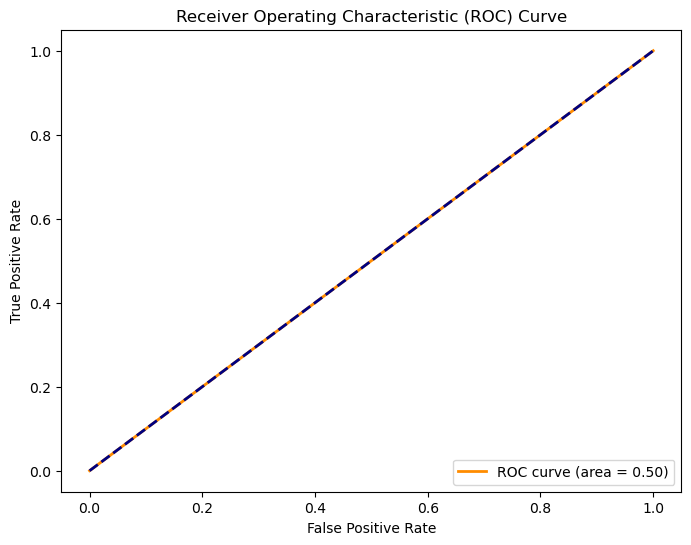

In [28]:

# ROC Curve
fpr, tpr, thresholds = roc_curve(val_labels, val_binary_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()